In [6]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

TRAINING = 227

csv_path = ".\historical_data_18_months.csv"

df = pd.read_csv(csv_path)

# Use company symbol to find all occurences
df.set_index('symbol', inplace=True)
stock_a = df.loc['A']

# Filter unwanted features
features_list = ['open', 'high', 'low', 'close']
features = df[features_list]

features.index = df['date']
features.head()

,open,high,low,close
date,,,,
2018-08-01,65.84,66.17,64.63,64.98
2018-08-02,64.75,65.39,64.50,65.29
2018-08-03,65.50,65.79,64.96,65.73
2018-08-06,65.70,66.66,65.33,66.51
2018-08-07,66.83,67.94,66.63,67.66


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AAD726B490>,
      dtype=object)

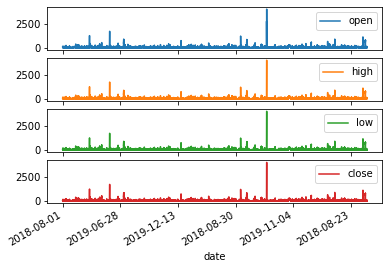

In [7]:
features.plot(subplots=True)

In [8]:
# Standardize the data
data = features.values
mean = data[:TRAINING].mean(axis=0)
std = data[:TRAINING].std(axis=0)
data = (data - mean) / std

In [9]:
x_train, y_train = multivariate_data(data, data[:, 1], 0,
                                     TRAINING, 30, 1, 1,
                                     single_step=True)
x_val, y_val = multivariate_data(data, data[:, 1],
                                 TRAINING, None, 
                                 30, 1, 1,
                                 single_step=True)
x_train[0].shape                        

(30, 4)

In [11]:
# Shuffle, Batch, and cache training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(10000).batch(256).repeat()

# Repeat for value data
valid_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
valid_data = valid_data.cache().batch(256).repeat()

In [12]:
# Run RNN w/ Long Short Term Memory Layer
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32,
                               input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

# Fit to Training data
step_hist = model.fit(train_data, epochs=10,
                      steps_per_epoch=200,
                      validation_data=valid_data,
                      validation_steps=50)

Epoch 1/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2150 - val_loss: 6.3460
Epoch 2/10
200/200 [==============================] - 10s 50ms/step - loss: 0.1661 - val_loss: 6.8331
Epoch 3/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1473 - val_loss: 6.9425
Epoch 4/10
200/200 [==============================] - 8s 39ms/step - loss: 0.1339 - val_loss: 7.2736
Epoch 5/10
200/200 [==============================] - 6s 32ms/step - loss: 0.1197 - val_loss: 7.2626
Epoch 6/10
200/200 [==============================] - 7s 36ms/step - loss: 0.1075 - val_loss: 7.4131
Epoch 7/10
200/200 [==============================] - 7s 34ms/step - loss: 0.0989 - val_loss: 7.5005
Epoch 8/10
200/200 [==============================] - 7s 33ms/step - loss: 0.0918 - val_loss: 7.5963
Epoch 9/10
200/200 [==============================] - 7s 35ms/step - loss: 0.0852 - val_loss: 7.6260
Epoch 10/10
200/200 [==============================] - 6s 32ms/step - loss: 0.0797 - val_l

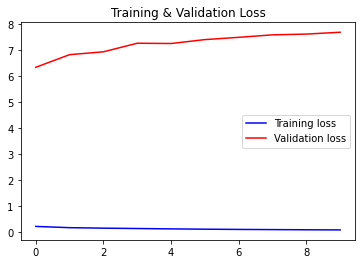

In [21]:
plot_history(step_hist,
             'Training & Validation Loss')

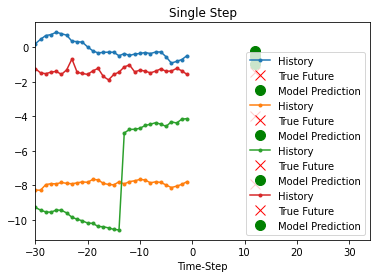

In [31]:
for x, y in valid_data.take(4):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                     model.predict(x)[0]], 12,
                     'Single Step')
plot.show()

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Create window based on data, step size, and given indices
    """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [19]:
def plot_history(history, title):
    """
        Plot given history
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [30]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = list(range(-plot_data[0].shape[0], 0 ))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt